# Vector Space Word Embeddings

*Sunny Li, MPP Student, Harris School of Public Policy, University of Chicago*

In this part, Word2Vec, Doc2Vec and Projection are used to help us understand the topics and influence of COVID19 in each of the three data sets and how the content may differ between different time and different states.

# Import packages

In [416]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import glob

import re
import string
from wordcloud import STOPWORDS

# Data Preparation

In this part, we will read all the twitter data and do basic processing on them. The tweet data we used was the tweets related to Covid19 in March. We will extract some of the columns in these datasets and calculate its sentiment scores using polarity scores based on the tweet content. After processing all the tweets, we divided them into three data sets according to the time they were generated: early, middle and late.

The early tweets included all tweets before March 12. The reason we chose this date as the time node is that this day is the day when Covid19 was determined to be a global pandemic. Mid-term tweets include all data from March 12 to March 20, while late tweets include all data from March 21 to March 31. In different analysis sections, we will use Early, Middle and Late to refer to the three datasets.

In [511]:
def new_sentence(text):
    '''
    This function is to clean a text with some regular expression methods. We
    want to return a new string with all marks and numbers deleted and all
    letters in the lower case format.

    Input:
    text (string): a text which needs to be processed.

    Ouput:
    new (string): a processed text.
    '''

    text = re.sub(r'[{}]+'.format(string.punctuation), '', text)
    text = re.sub(r'[{}]+'.format(string.digits), '', text)
    word_list = text.strip().lower().split()
    picked_words = [word for word in word_list if word not in STOPWORDS]
    new = ' '.join(picked_words)
    return new

In [512]:
def add_tokenized_nomalized_sents(df):
    '''
    This function is to extract necessary columns from a dataframe and 
    add two columns to describ the tokenized and nomalized of the text
    and one column to descrie the date of the text.
    
    Input:
    df (DataFrame): a DataFrame with needs to be processed.
    
    Output:
    df (DataFrame): a processed DataFrame.
    '''
    df = df[['status_id','user_id','created_at','screen_name','text','followers_count','friends_count']]
    df['text'] = df['text'].astype(str)
    df['clean_text'] = df['text'].apply(new_sentence)
    df['created_at'] = df['created_at'].astype(str)
    df['tokenized_sents'] = df['clean_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
    df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
    return df

In [513]:
def add_date(df):
    '''
    This function is to add one column to descrie the date of the text.
    
    Input:
    df (DataFrame): a DataFrame with needs to be processed.
    
    Output:
    df (DataFrame): a processed DataFrame.
    '''
    df['date'] = df['created_at']
    for i,time in enumerate(df['created_at']):
        if i <= len(df['created_at']):
            df['date'][i:i+1]=time[:10]
        
    #df['date'] = df['date'].astype(str)
    return df

In [514]:
def read_path_csv(path):
    '''
    This function is to get a DataFrame from a csv, extract necessary columns 
    and add two columns to describing the tokenized and nomalized of the text.
    
    Input:
    path (string): the path of a csv to be read
    
    Output:
    df (DataFrame): a processed DataFrame
    '''
    allFiles = glob.glob(path + "/*.CSV")
    
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    return frame

In [515]:
path ='/Users/sunny/CCA 2020/slim_tweets_0125' 
early_path = path +'/early'
middle_path = path +'/middle'
late_path = path +'/late'

In [516]:
t_early_df = read_path_csv(early_path)

In [517]:
t_early_df = read_path_csv(early_path)
t_middle_df = read_path_csv(middle_path)
t_late_df = read_path_csv(late_path)

In [423]:
def reduce_mem_usage(df, verbose=True):
    '''
    This function is to reduce the DataFrame size while keep all the valuable information.
    
    Input:
    df (DataFrame): a DataFrame with needs to be processed.
    
    Output:
    df (DataFrame): a processed DataFrame
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                     df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [518]:
t_early_df = reduce_mem_usage(t_early_df)
t_middle_df = reduce_mem_usage(t_middle_df)
t_late_df = reduce_mem_usage(t_late_df)

Mem. usage decreased to  0.53 Mb (22.2% reduction)
Mem. usage decreased to  6.10 Mb (17.0% reduction)
Mem. usage decreased to  7.04 Mb (21.2% reduction)


In [425]:
t_early = add_tokenized_nomalized_sents(t_early_df)
t_middle = add_tokenized_nomalized_sents(t_middle_df)
t_late = add_tokenized_nomalized_sents(t_late_df)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [426]:
t_early = add_date(t_early)
t_middle = add_date(t_middle)
t_late = add_date(t_late)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

In [482]:
tweets = pd.concat([t_early,t_middle,t_late])

,Unnamed: 0,clean_text,created_at,date,followers_count,friends_count,normalized_sents,normalized_tokens,reduced_tokens,screen_name,sentiment,sentiment_scores,status_id,text,tokenized_sents,tokenized_text,user_id
0,0,remember shudder superb ben elton sketch last ...,2020-03-08T10:31:23Z,NaN,155.0,197.0,NaN,"['remember', 'shudder', 'superb', 'ben', 'elto...","['remember', 'way', 'covid_19']",GarySch47413717,-1.0,"{'neg': 0.252, 'neu': 0.579, 'pos': 0.169, 'co...",1.236600e+18,I remember this with a shudder. A superb Ben E...,NaN,"['I', 'remember', 'this', 'with', 'a', 'shudde...",1.113032e+18
1,1,people die coronavirus gravestones say quarand...,2020-03-11T11:17:42Z,NaN,13.0,57.0,NaN,"['people', 'die', 'coronavirus', 'gravestone',...","['people', 'die', 'coronavirus', 'coronavirus']",KritikaSiroliya,-1.0,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...",1.237699e+18,People who die because of Coronavirus should h...,NaN,"['People', 'who', 'die', 'because', 'of', 'Cor...",1.215211e+18
2,2,authackeray officeofut prevention better cure ...,2020-03-07T20:56:13Z,NaN,38.0,106.0,NaN,"['@authackeray', '@officeofut', 'prevention', ...","['prevention', 'cure', 'urge', 'amp', 'school'...",kumar_2302,1.0,"{'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'comp...",1.236395e+18,@AUThackeray @OfficeofUT \n\nPrevention is bet...,NaN,"['@AUThackeray', '@OfficeofUT', 'Prevention', ...",3.248120e+08
3,3,sobering assessment every country still contai...,2020-03-11T17:30:58Z,NaN,2712.0,4994.0,NaN,"['sober', 'assessment', 'country', 'contain', ...","['country', 'contain', 'mitigate', 'impact']",HEARDatUNSW,-1.0,"{'neg': 0.129, 'neu': 0.719, 'pos': 0.151, 'co...",1.237793e+18,Sobering assessment; every country should be d...,NaN,"['Sobering', 'assessment', 'every', 'country',...",3.868509e+08
4,4,even good beat covid alaskans going take huge ...,2020-03-11T22:24:15Z,NaN,713.0,247.0,NaN,"['good', 'beat', 'covid19', 'alaskans', 'go', ...","['good', 'huge', 'financial', 'hit', 'oil', 'w...",mspanish,1.0,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...",1.237867e+18,"Even if we get a good beat on #covid19, Alaska...",NaN,"['Even', 'if', 'we', 'get', 'a', 'good', 'beat...",1.952652e+07


In [428]:
tweets.to_csv(path+'/tweets.CSV')
t_early.to_csv(path+'/t_early.CSV')
t_middle.to_csv(path+'/t_middle.CSV')
t_late.to_csv(path+'/t_late.CSV')

In [429]:
# since the tokenized and normalized process takes more than an hour, 
# I save the results and read the results for future use
tweets=pd.read_csv(path+'/tweets.CSV')
t_early=pd.read_csv(path+'/t_early.CSV')
t_middle=pd.read_csv(path+'/t_middle.CSV')
t_late=pd.read_csv(path+'/t_late.CSV')

In [522]:
tweets=pd.read_csv(path+'/tweets.CSV')

In [523]:
tweets.head()

,Unnamed: 0,status_id,user_id,created_at,screen_name,text,followers_count,friends_count,clean_text,tokenized_sents,normalized_sents,date
0,0,1.236600e+18,1.113032e+18,2020-03-08T10:31:23Z,GarySch47413717,I remember this with a shudder. A superb Ben E...,155.0,197.0,remember shudder superb ben elton sketch last ...,"[['remember', 'shudder', 'superb', 'ben', 'elt...","[['remember', 'shudder', 'superb', 'ben', 'elt...",2020-03-08
1,1,1.237699e+18,1.215211e+18,2020-03-11T11:17:42Z,KritikaSiroliya,People who die because of Coronavirus should h...,13.0,57.0,people die coronavirus gravestones say quarand...,"[['people', 'die', 'coronavirus', 'gravestones...","[['people', 'die', 'coronavirus', 'gravestones...",2020-03-11
2,2,1.236395e+18,3.248120e+08,2020-03-07T20:56:13Z,kumar_2302,@AUThackeray @OfficeofUT \n\nPrevention is bet...,38.0,106.0,authackeray officeofut prevention better cure ...,"[['authackeray', 'officeofut', 'prevention', '...","[['authackeray', 'officeofut', 'prevention', '...",2020-03-07
3,3,1.237793e+18,3.868509e+08,2020-03-11T17:30:58Z,HEARDatUNSW,Sobering assessment; every country should be d...,2712.0,4994.0,sobering assessment every country still contai...,"[['sobering', 'assessment'], ['every', 'countr...","[['sobering', 'assessment'], ['country', 'cont...",2020-03-11
4,4,1.237867e+18,1.952652e+07,2020-03-11T22:24:15Z,mspanish,"Even if we get a good beat on #covid19, Alaska...",713.0,247.0,even good beat covid alaskans going take huge ...,"[['even', 'good', 'beat', 'covid', 'alaskans',...","[['good', 'beat', 'covid', 'alaskans', 'going'...",2020-03-11


In [431]:
print('Size of t_early data', t_early.shape)
print('Size of t_middle data', t_middle.shape)
print('Size of t_late data', t_late.shape)
print('Size of tweets data', tweets.shape)

Size of t_early data (4144, 12)
Size of t_middle data (38555, 12)
Size of t_late data (52327, 12)
Size of tweets data (95026, 12)


# Word2Vec

In this part, We will use the gensim implementation of Word2Vec.

To load our data we give all the sentences to the trainer:

In [471]:
t_early=pd.read_csv('/Users/sunny/CCA 2020/early.csv')

In [474]:
t_early.head()

,Unnamed: 0,status_id,user_id,created_at,screen_name,text,followers_count,friends_count,clean_text,sentiment_scores,sentiment,tokenized_text,normalized_tokens,reduced_tokens
0,0,1236600394521939968,1113032338844385280,2020-03-08T10:31:23Z,GarySch47413717,I remember this with a shudder. A superb Ben E...,155,197,remember shudder superb ben elton sketch last ...,"{'neg': 0.252, 'neu': 0.579, 'pos': 0.169, 'co...",-1,"['I', 'remember', 'this', 'with', 'a', 'shudde...","['remember', 'shudder', 'superb', 'ben', 'elto...","['remember', 'way', 'covid_19']"
1,1,1237699213489823744,1215211250935828480,2020-03-11T11:17:42Z,KritikaSiroliya,People who die because of Coronavirus should h...,13,57,people die coronavirus gravestones say quarand...,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...",-1,"['People', 'who', 'die', 'because', 'of', 'Cor...","['people', 'die', 'coronavirus', 'gravestone',...","['people', 'die', 'coronavirus', 'coronavirus']"
2,2,1236395251008323584,324812029,2020-03-07T20:56:13Z,kumar_2302,@AUThackeray @OfficeofUT \n\nPrevention is bet...,38,106,authackeray officeofut prevention better cure ...,"{'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'comp...",1,"['@AUThackeray', '@OfficeofUT', 'Prevention', ...","['@authackeray', '@officeofut', 'prevention', ...","['prevention', 'cure', 'urge', 'amp', 'school'..."
3,3,1237793147825967104,386850910,2020-03-11T17:30:58Z,HEARDatUNSW,Sobering assessment; every country should be d...,2712,4994,sobering assessment every country still contai...,"{'neg': 0.129, 'neu': 0.719, 'pos': 0.151, 'co...",-1,"['Sobering', 'assessment', 'every', 'country',...","['sober', 'assessment', 'country', 'contain', ...","['country', 'contain', 'mitigate', 'impact']"
4,4,1237866955127701506,19526523,2020-03-11T22:24:15Z,mspanish,"Even if we get a good beat on #covid19, Alaska...",713,247,even good beat covid alaskans going take huge ...,"{'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...",1,"['Even', 'if', 'we', 'get', 'a', 'good', 'beat...","['good', 'beat', 'covid19', 'alaskans', 'go', ...","['good', 'huge', 'financial', 'hit', 'oil', 'w..."


In [452]:
t_middle_w2v = gensim.models.word2vec.Word2Vec.load("t_middle_w2v")
t_late_w2v = gensim.models.word2vec.Word2Vec.load("t_late_w2v")

In [458]:
print(t_middle_w2v.similarity('italy', 'covid'))

0.2846956


In [459]:
print(t_late_w2v.similarity('italy', 'covid'))

0.34508565


In [477]:
t_early_w2v = gensim.models.word2vec.Word2Vec(t_early['normalized_tokens'].sum())

In [432]:
t_early_w2v = gensim.models.word2vec.Word2Vec(t_early['normalized_sents'].sum())
t_middle_w2v = gensim.models.word2vec.Word2Vec(t_middle['normalized_sents'].sum())
t_late_w2v = gensim.models.word2vec.Word2Vec(t_late['normalized_sents'].sum())

## *early*

In [478]:
t_early_w2v.wv.index2word[:20] 

["'",
 ',',
 ' ',
 'e',
 'o',
 'a',
 't',
 'i',
 'r',
 'c',
 'n',
 's',
 'l',
 'd',
 'u',
 'p',
 'v',
 'h',
 'm',
 '/']

In [454]:
# All words contained here
t_middle_w2v.wv.index2word[:20] 

['coronavirus',
 'covid',
 'people',
 'coronaviruspandemic',
 'amp',
 'coronavirusoutbreak',
 'nt',
 'time',
 'home',
 'virus',
 'pandemic',
 'need',
 'cases',
 'help',
 'm',
 'health',
 'new',
 'trump',
 'stay',
 'know']

In [480]:
t_late_w2v.wv.index2word[:40] 

['covid',
 'coronavirus',
 'people',
 'amp',
 'coronaviruspandemic',
 'nt',
 'cases',
 'home',
 'pandemic',
 'new',
 'time',
 'help',
 'stay',
 'need',
 'lockdown',
 'health',
 'virus',
 'coronavirusoutbreak',
 'world',
 'support',
 'day',
 'trump',
 'm',
 'covidー',
 'china',
 '️',
 'today',
 'spread',
 'stayhome',
 'know',
 'deaths',
 'quarantine',
 'corona',
 'safe',
 'work',
 'crisis',
 'italy',
 'going',
 's',
 'realdonaldtrump']

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (__getitem__) method:

If you want the full matrix, syn0 stores all the vectors:

In [42]:
t_early_w2v.wv.syn0

array([[ 1.63226932e-01, -1.16290428e-01, -6.18352413e-01, ...,
        -6.95615336e-02,  3.61301154e-01,  3.70011330e-01],
       [ 1.45105392e-01, -9.60146710e-02, -5.61629593e-01, ...,
        -6.49905577e-02,  3.23455691e-01,  3.39883149e-01],
       [ 1.56325936e-01, -1.04804106e-01, -5.72453976e-01, ...,
        -6.99788257e-02,  3.31911892e-01,  3.42949301e-01],
       ...,
       [ 1.60827935e-02, -1.05341813e-02, -4.55080904e-02, ...,
        -9.36503347e-05,  2.61557885e-02,  2.21507382e-02],
       [ 1.00528626e-02, -6.73499843e-03, -4.79456969e-02, ...,
        -9.59779974e-03,  2.60748640e-02,  3.11321020e-02],
       [ 4.04626504e-03, -2.93835346e-03, -2.35369010e-03, ...,
         3.66975274e-03, -1.16809667e-03,  3.56321153e-03]], dtype=float32)

In [41]:
t_early_w2v.wv.index2word[7]

'virus'

In [414]:
t_early_w2v.save("t_early_w2v")

**Most similar words**

In [49]:
t_early_w2v.most_similar('mask',topn=20)

[('amp', 0.9998902082443237),
 ('good', 0.9998898506164551),
 ('time', 0.9998846054077148),
 ('risk', 0.9998832941055298),
 ('infected', 0.9998812675476074),
 ('people', 0.9998801946640015),
 ('home', 0.9998794198036194),
 ('realdonaldtrump', 0.9998774528503418),
 ('travel', 0.9998734593391418),
 ('news', 0.9998728632926941),
 ('coronavirusoutbreak', 0.9998726844787598),
 ('going', 0.9998713731765747),
 ('work', 0.9998711347579956),
 ('disease', 0.9998705983161926),
 ('events', 0.9998697638511658),
 ('public', 0.9998685717582703),
 ('today', 0.9998675584793091),
 ('measures', 0.9998674392700195),
 ('want', 0.9998674392700195),
 ('let', 0.9998658895492554)]

In [460]:
t_middle_w2v.most_similar('mask',topn=20)

[('wear', 0.9858874678611755),
 ('sanitize', 0.9849362373352051),
 ('seconds', 0.9805561304092407),
 ('ur', 0.9802078008651733),
 ('nose', 0.9786962270736694),
 ('kind', 0.9784952402114868),
 ('touch', 0.9781644940376282),
 ('drink', 0.9773752689361572),
 ('thoroughly', 0.9765998125076294),
 ('sensible', 0.9763309955596924),
 ('🍃', 0.9758017063140869),
 ('eat', 0.9757019281387329),
 ('wearing', 0.974125862121582),
 ('clean', 0.9724180698394775),
 ('plenty', 0.9715790748596191),
 ('disinfect', 0.9714343547821045),
 ('regularly', 0.9712313413619995),
 ('touching', 0.9707162380218506),
 ('warm', 0.9693801403045654),
 ('bath', 0.9692705869674683)]

In [461]:
t_late_w2v.most_similar('mask',topn=20)

[('wear', 0.967120349407196),
 ('face', 0.9614160656929016),
 ('wearing', 0.9601844549179077),
 ('gloves', 0.9428987503051758),
 ('n', 0.9079297780990601),
 ('masks', 0.8997634649276733),
 ('sanitizer', 0.8979142308235168),
 ('surgical', 0.8917690515518188),
 ('hand', 0.8855747580528259),
 ('nose', 0.8747954368591309),
 ('water', 0.8602918386459351),
 ('capes', 0.8543741703033447),
 ('wore', 0.84669429063797),
 ('touching', 0.8457788825035095),
 ('use', 0.8438397645950317),
 ('buy', 0.840024471282959),
 ('shields', 0.8393199443817139),
 ('touch', 0.838141679763794),
 ('soap', 0.8369647264480591),
 ('sew', 0.831843376159668)]

In [51]:
t_early_w2v.most_similar('home',topn=20)

[('people', 0.9999382495880127),
 ('amp', 0.9999343752861023),
 ('good', 0.9999293088912964),
 ('care', 0.9999274015426636),
 ('going', 0.9999245405197144),
 ('day', 0.9999244213104248),
 ('time', 0.9999239444732666),
 ('help', 0.9999208450317383),
 ('world', 0.9999189376831055),
 ('response', 0.9999170899391174),
 ('nt', 0.9999159574508667),
 ('health', 0.9999151229858398),
 ('need', 0.9999145269393921),
 ('virus', 0.9999116659164429),
 ('said', 0.9999115467071533),
 ('days', 0.9999114871025085),
 ('social', 0.9999113082885742),
 ('stop', 0.9999112486839294),
 ('public', 0.9999111294746399),
 ('trump', 0.9999095797538757)]

In [56]:
t_early_w2v.most_similar('employment',topn=20)

[('die', 0.9993382096290588),
 ('away', 0.9993132948875427),
 ('m', 0.9993005394935608),
 ('think', 0.9992945194244385),
 ('italy', 0.9992908239364624),
 ('fear', 0.9992795586585999),
 ('tested', 0.9992743730545044),
 ('data', 0.9992733001708984),
 ('cancelled', 0.9992719888687134),
 ('getting', 0.9992671012878418),
 ('want', 0.9992666840553284),
 ('times', 0.9992642402648926),
 ('care', 0.9992638826370239),
 ('realdonaldtrump', 0.9992605447769165),
 ('coronavirus', 0.999258816242218),
 ('india', 0.999258279800415),
 ('covidー', 0.9992527365684509),
 ('virus', 0.9992525577545166),
 ('response', 0.999252438545227),
 ('need', 0.9992511868476868)]

In [58]:
t_early_w2v.most_similar('health',topn=20)

[('today', 0.9999427795410156),
 ('amp', 0.9999422430992126),
 ('covid', 0.9999370574951172),
 ('days', 0.9999346733093262),
 ('world', 0.9999346733093262),
 ('trump', 0.9999333620071411),
 ('virus', 0.999932587146759),
 ('public', 0.9999325275421143),
 ('state', 0.9999310970306396),
 ('good', 0.9999294281005859),
 ('need', 0.9999276399612427),
 ('coronavirusoutbreak', 0.9999273419380188),
 ('travel', 0.9999265074729919),
 ('realdonaldtrump', 0.9999251365661621),
 ('people', 0.9999246001243591),
 ('s', 0.99992436170578),
 ('care', 0.999923825263977),
 ('medical', 0.9999215602874756),
 ('coronavirus', 0.9999212622642517),
 ('nt', 0.9999210238456726)]

In [59]:
t_early_w2v.most_similar('hospital',topn=20)

[('virus', 0.999919056892395),
 ('public', 0.9999136328697205),
 ('people', 0.9999065399169922),
 ('need', 0.9999006390571594),
 ('amp', 0.9999006390571594),
 ('italy', 0.999900221824646),
 ('health', 0.9998992681503296),
 ('coronavirus', 0.999894380569458),
 ('days', 0.9998915195465088),
 ('uk', 0.9998911619186401),
 ('care', 0.9998905658721924),
 ('flu', 0.9998903870582581),
 ('covid', 0.9998888969421387),
 ('spread', 0.9998885989189148),
 ('state', 0.9998881220817566),
 ('time', 0.9998878836631775),
 ('s', 0.9998878240585327),
 ('travel', 0.9998857378959656),
 ('said', 0.9998840093612671),
 ('world', 0.999883770942688)]

In [60]:
t_early_w2v.most_similar('quarantine',topn=20)

[('people', 0.9999161958694458),
 ('days', 0.9999080896377563),
 ('italy', 0.9999054074287415),
 ('need', 0.9999039769172668),
 ('travel', 0.9999028444290161),
 ('public', 0.9999025464057922),
 ('amp', 0.999899685382843),
 ('day', 0.9998995065689087),
 ('care', 0.9998987913131714),
 ('coronavirusoutbreak', 0.9998986721038818),
 ('s', 0.9998934268951416),
 ('world', 0.9998931884765625),
 ('time', 0.9998912811279297),
 ('disease', 0.9998911619186401),
 ('work', 0.9998911619186401),
 ('covid', 0.9998908638954163),
 ('state', 0.999889612197876),
 ('said', 0.9998894333839417),
 ('countries', 0.9998888373374939),
 ('medical', 0.9998887777328491)]

**Word that is most different from the set**

In [62]:
print(t_early_w2v.similarity('employment', 'covid'))

0.9992413


In [63]:
print(t_early_w2v.similarity('quarantine', 'covid'))

0.99989086


In [64]:
print(t_early_w2v.similarity('hospital', 'covid'))

0.99988896


In [462]:
print(t_middle_w2v.similarity('coronavirus', 'mask'))

0.47449237


In [463]:
print(t_late_w2v.similarity('coronavirus', 'mask'))

0.12753427


In [65]:
print(t_early_w2v.similarity('coronavirus', 'mask'))

0.9998476


In [66]:
print(t_early_w2v.similarity('quarantine', 'home'))

0.9998794


In [69]:
print(t_early_w2v.similarity('mask', 'need'))

0.9998653


**word relations**

In [71]:
# 'coronavirus'+'unemployment' - 'quarantine'
t_early_w2v.most_similar(positive = ['coronavirus','employment'], negative = ['quarantine'], topn = 10)

[('die', 0.9991424083709717),
 ('away', 0.9991337656974792),
 ('fear', 0.9991298317909241),
 ('m', 0.9991172552108765),
 ('italy', 0.9991074800491333),
 ('cancelled', 0.9991071224212646),
 ('think', 0.9991060495376587),
 ('want', 0.9991023540496826),
 ('data', 0.9991004467010498),
 ('response', 0.999096691608429)]

In [464]:
t_middle_w2v.most_similar(positive = ['coronavirus','employment'], negative = ['quarantine'], topn = 10)

[('economic', 0.8247387409210205),
 ('global', 0.8133828043937683),
 ('declared', 0.810341477394104),
 ('economy', 0.8101247549057007),
 ('funds', 0.8061999082565308),
 ('drtedros', 0.7959733605384827),
 ('classified', 0.795128583908081),
 ('usnews', 0.7911975383758545),
 ('declares', 0.789726972579956),
 ('praises', 0.788289487361908)]

In [465]:
t_late_w2v.most_similar(positive = ['coronavirus','employment'], negative = ['quarantine'], topn = 10)

[('global', 0.807831346988678),
 ('humanitarian', 0.7811460494995117),
 ('funds', 0.7688217163085938),
 ('current', 0.76557856798172),
 ('combined', 0.7651761770248413),
 ('financial', 0.7604192495346069),
 ('facing', 0.7594742774963379),
 ('coordinated', 0.7592013478279114),
 ('dispatched', 0.7566924691200256),
 ('immediate', 0.7556937336921692)]

**visualize**

In [72]:
len(t_early_w2v.wv.index2word)

2145

In [73]:
numWords = 100 
targetWords = t_early_w2v.wv.index2word[:numWords]

In [75]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(t_early_w2v[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.16322693, -0.11629043, -0.6183524 , ..., -0.06956153,
         0.36130115,  0.37001133],
       [ 0.14510539, -0.09601467, -0.5616296 , ..., -0.06499056,
         0.3234557 ,  0.33988315],
       [ 0.15632594, -0.10480411, -0.572454  , ..., -0.06997883,
         0.3319119 ,  0.3429493 ],
       ...,
       [ 0.08857566, -0.06146147, -0.32874492, ..., -0.03564436,
         0.18923618,  0.19938326],
       [ 0.08881623, -0.05360539, -0.32891825, ..., -0.03335999,
         0.19133604,  0.19659607],
       [ 0.08744194, -0.05633709, -0.32238993, ..., -0.0351497 ,
         0.19160405,  0.19956177]], dtype=float32)

In [76]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

In [77]:
def plot_words(tsneWords):
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


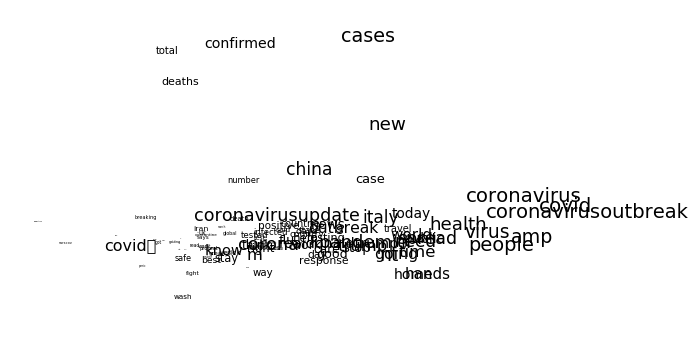

In [78]:
# PCA
PCAWords = sklearn.decomposition.PCA(n_components = 2).fit_transform(wordsSubMatrix)
plot_words(PCAWords)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


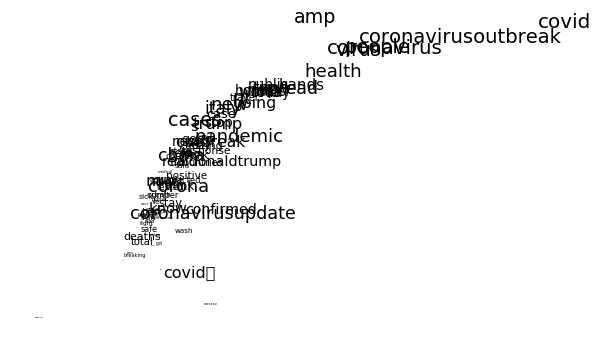

In [79]:
# Multidimensional scaling
MDSWords = sklearn.manifold.MDS(n_components = 2).fit_transform(reducedPCA_data)
plot_words(MDSWords)

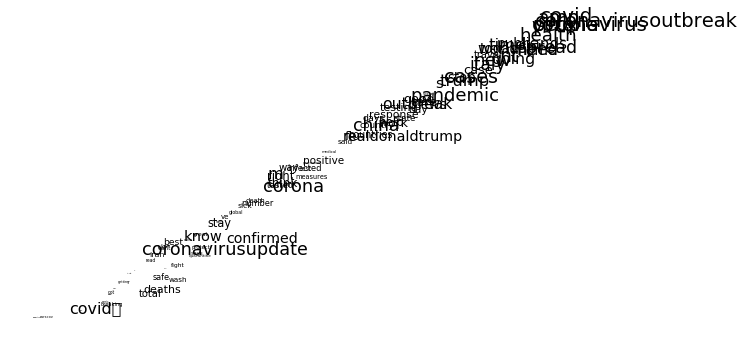

In [80]:
plot_words(tsneWords)

## *middle*

In [81]:
# All words contained here
t_middle_w2v.wv.index2word[:20] 

['coronavirus',
 'covid',
 'people',
 'coronaviruspandemic',
 'amp',
 'coronavirusoutbreak',
 'nt',
 'time',
 'home',
 'virus',
 'pandemic',
 'need',
 'cases',
 'help',
 'm',
 'health',
 'new',
 'trump',
 'stay',
 'know']

In [82]:
t_middle_w2v['coronavirus'][:10] 

array([-0.49348456,  0.0255612 ,  0.06599437,  0.8144327 , -0.44433025,
       -0.2331172 , -0.23514338,  0.3632525 ,  0.16839358, -0.08635192],
      dtype=float32)

In [83]:
t_middle_w2v.wv.syn0

array([[-4.9348456e-01,  2.5561199e-02,  6.5994374e-02, ...,
        -4.5959648e-01,  5.3377670e-01,  3.1665513e-01],
       [-2.8710532e-01, -2.1960141e-01, -9.1117717e-02, ...,
        -6.1468095e-02,  3.2110280e-01, -1.0096670e-01],
       [ 2.5215021e-01,  6.5872693e-01, -3.8896951e-01, ...,
         1.9220991e-01,  7.3852527e-01,  8.1186724e-01],
       ...,
       [ 1.0016229e-02,  9.7308746e-03, -4.9911484e-02, ...,
        -5.1587604e-02,  8.2920127e-02,  1.6701726e-02],
       [-4.3328031e-04,  1.1258202e-02, -1.1741575e-02, ...,
        -2.5204502e-02,  3.7352148e-02,  2.4860012e-03],
       [-8.4255816e-04,  1.8185548e-02, -2.6574000e-03, ...,
        -2.2451445e-02,  3.0652799e-02,  1.3957654e-02]], dtype=float32)

In [84]:
t_middle_w2v.save("t_middle_w2v")

**Most similar words**

In [85]:
t_middle_w2v.most_similar('covid',topn=20)

[('coronavirus', 0.8626343607902527),
 ('covidindia', 0.8501474857330322),
 ('coronavirusinindia', 0.8401685953140259),
 ('coronaindia', 0.8401656150817871),
 ('narendramodi', 0.8393934965133667),
 ('coronavirusoutbreak', 0.8345302939414978),
 ('coronavirusindia', 0.8344253301620483),
 ('covidtr', 0.8340815305709839),
 ('coronavirüsü', 0.8314062356948853),
 ('covidー', 0.8302003145217896),
 ('coronavirusoutbreakindia', 0.8296473026275635),
 ('coronaalert', 0.8293160200119019),
 ('sarscov', 0.8272903561592102),
 ('novelcoronavirus', 0.8260398507118225),
 ('coronauk', 0.8245428800582886),
 ('coronainmaharashtra', 0.8232631087303162),
 ('coronavirusupdates', 0.8229470252990723),
 ('shutdownnyc', 0.82228684425354),
 ('coronaviruspakistan', 0.8219611644744873),
 ('coronavirusinpakistan', 0.8173189759254456)]

In [86]:
t_middle_w2v.most_similar('mask',topn=20)

[('wear', 0.9858874678611755),
 ('sanitize', 0.9849362373352051),
 ('seconds', 0.9805561304092407),
 ('ur', 0.9802078008651733),
 ('nose', 0.9786962270736694),
 ('kind', 0.9784952402114868),
 ('touch', 0.9781644940376282),
 ('drink', 0.9773752689361572),
 ('thoroughly', 0.9765998125076294),
 ('sensible', 0.9763309955596924),
 ('🍃', 0.9758017063140869),
 ('eat', 0.9757019281387329),
 ('wearing', 0.974125862121582),
 ('clean', 0.9724180698394775),
 ('plenty', 0.9715790748596191),
 ('disinfect', 0.9714343547821045),
 ('regularly', 0.9712313413619995),
 ('touching', 0.9707162380218506),
 ('warm', 0.9693801403045654),
 ('bath', 0.9692705869674683)]

In [87]:
t_middle_w2v.most_similar('home',topn=20)

[('tuned', 0.8984594345092773),
 ('nan', 0.8886526823043823),
 ('safe', 0.865440845489502),
 ('away', 0.8497706651687622),
 ('inside', 0.8330562114715576),
 ('healthy', 0.830906867980957),
 ('indoors', 0.817022442817688),
 ('remotely', 0.81437087059021),
 ('sane', 0.8035402894020081),
 ('informed', 0.7821871638298035),
 ('remote', 0.7819668650627136),
 ('connected', 0.7784995436668396),
 ('calm', 0.7719186544418335),
 ('strong', 0.7698090076446533),
 ('self', 0.7694422602653503),
 ('open', 0.7634932994842529),
 ('needful', 0.7579818367958069),
 ('afloat', 0.7551501393318176),
 ('kids', 0.7510143518447876),
 ('parents', 0.7466272711753845)]

In [88]:
t_middle_w2v.most_similar('employment',topn=20)

[('tackling', 0.9934539794921875),
 ('palestinian', 0.9932538270950317),
 ('demonstrated', 0.9930591583251953),
 ('summary', 0.9928123950958252),
 ('ncnews', 0.992802619934082),
 ('evolving', 0.9926767349243164),
 ('surrounding', 0.9923166036605835),
 ('counter', 0.9921796321868896),
 ('wordpress', 0.991962730884552),
 ('slowdown', 0.9919548034667969),
 ('teamwork', 0.9919338226318359),
 ('catastrophe', 0.9918642044067383),
 ('fraud', 0.9916468262672424),
 ('infectiousdisease', 0.9916419982910156),
 ('bbhuttozardari', 0.9914300441741943),
 ('eucommission', 0.9913809299468994),
 ('regards', 0.9912583231925964),
 ('implications', 0.9912539720535278),
 ('mitigation', 0.9909324645996094),
 ('financialtimes', 0.9907127022743225)]

In [89]:
t_middle_w2v.most_similar('health',topn=20)

[('public', 0.9178040027618408),
 ('organization', 0.8528395295143127),
 ('safety', 0.8522771596908569),
 ('medical', 0.8454006910324097),
 ('system', 0.8369561433792114),
 ('emergency', 0.8356432914733887),
 ('advice', 0.8335756063461304),
 ('officials', 0.828551173210144),
 ('care', 0.8267948627471924),
 ('healthcare', 0.8220754861831665),
 ('mental', 0.8195760250091553),
 ('department', 0.8102734088897705),
 ('government', 0.8091913461685181),
 ('transport', 0.8054165840148926),
 ('underlying', 0.8053796291351318),
 ('govt', 0.8046690821647644),
 ('measures', 0.8009821772575378),
 ('state', 0.7993240356445312),
 ('hospitals', 0.7971973419189453),
 ('issues', 0.7932226657867432)]

In [90]:
t_middle_w2v.most_similar('hospital',topn=20)

[('patients', 0.9574885964393616),
 ('hospitals', 0.9547406435012817),
 ('beds', 0.92880779504776),
 ('including', 0.9200869798660278),
 ('private', 0.9179971218109131),
 ('available', 0.9147815704345703),
 ('capacity', 0.9135773181915283),
 ('facilities', 0.9127744436264038),
 ('high', 0.9123623371124268),
 ('intensive', 0.9029070138931274),
 ('member', 0.8986437320709229),
 ('icu', 0.8941500782966614),
 ('labs', 0.8912094831466675),
 ('underlying', 0.890540599822998),
 ('officials', 0.8903740048408508),
 ('currently', 0.890045166015625),
 ('treatment', 0.8859425187110901),
 ('city', 0.8858098983764648),
 ('testing', 0.8833985328674316),
 ('center', 0.8826614618301392)]

In [91]:
t_middle_w2v.most_similar('quarantine',topn=20)

[('خليكبالبيت', 0.8945896625518799),
 ('selfisolation', 0.8538191318511963),
 ('isolation', 0.8465244770050049),
 ('self', 0.8437603712081909),
 ('socialdistancing', 0.8277859687805176),
 ('isolate', 0.8200931549072266),
 ('bored', 0.8097479343414307),
 ('selfisolating', 0.8011985421180725),
 ('workfromhome', 0.800790011882782),
 ('roommate', 0.7980908751487732),
 ('stayinghome', 0.7936655879020691),
 ('isolating', 0.7878254055976868),
 ('dankmemes', 0.7863516807556152),
 ('tuberculosis', 0.7858356237411499),
 ('💜', 0.7848494648933411),
 ('communityquarantine', 0.7841397523880005),
 ('cuarentenatotal', 0.7780638933181763),
 ('socialdistanacing', 0.776846706867218),
 ('stuck', 0.7678758502006531),
 ('loop', 0.7664186954498291)]

**Word that is most different from the set**

In [131]:
print(t_middle_w2v.similarity('china', 'covid'))

0.4429376


In [92]:
print(t_middle_w2v.similarity('employment', 'covid'))

0.6803553


In [93]:
print(t_middle_w2v.similarity('quarantine', 'covid'))

0.54670644


In [94]:
print(t_middle_w2v.similarity('hospital', 'covid'))

0.3921402


In [95]:
print(t_middle_w2v.similarity('coronavirus', 'mask'))

0.47449237


In [96]:
print(t_middle_w2v.similarity('quarantine', 'home'))

0.5859329


In [97]:
print(t_middle_w2v.similarity('mask', 'need'))

0.8226154


**word relations**

In [98]:
# 'coronavirus'+'unemployment' - 'quarantine'
t_middle_w2v.most_similar(positive = ['coronavirus','employment'], negative = ['quarantine'], topn = 10)

[('economic', 0.8247387409210205),
 ('global', 0.8133828043937683),
 ('declared', 0.810341477394104),
 ('economy', 0.8101247549057007),
 ('funds', 0.8061999082565308),
 ('drtedros', 0.7959733605384827),
 ('classified', 0.795128583908081),
 ('usnews', 0.7911975383758545),
 ('declares', 0.789726972579956),
 ('praises', 0.788289487361908)]

**visualize**

In [99]:
len(t_middle_w2v.wv.index2word)

10429

In [100]:
numWords = 100 
targetWords = t_middle_w2v.wv.index2word[:numWords]

In [101]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(t_middle_w2v[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.49348456,  0.0255612 ,  0.06599437, ..., -0.45959648,
         0.5337767 ,  0.31665513],
       [-0.28710532, -0.21960141, -0.09111772, ..., -0.06146809,
         0.3211028 , -0.1009667 ],
       [ 0.2521502 ,  0.65872693, -0.3889695 , ...,  0.19220991,
         0.7385253 ,  0.81186724],
       ...,
       [ 0.02666854,  0.38857287, -0.43082663, ..., -0.4554021 ,
         0.36176234,  0.69486374],
       [ 0.10162496,  0.56467295, -0.27476013, ..., -0.22995397,
         0.41476938,  0.66765726],
       [-0.05164094,  0.3893625 , -0.22556074, ..., -0.13471968,
         0.4323073 ,  0.6590376 ]], dtype=float32)

In [102]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


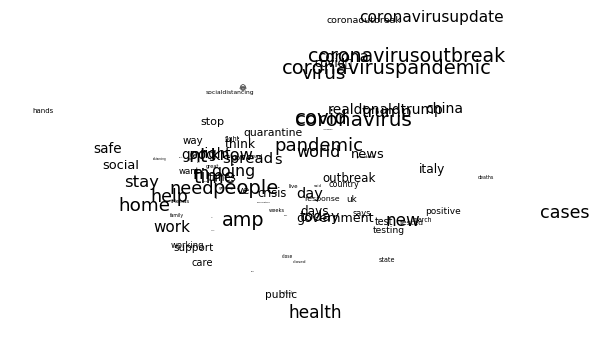

In [103]:
# PCA
PCAWords = sklearn.decomposition.PCA(n_components = 2).fit_transform(wordsSubMatrix)
plot_words(PCAWords)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


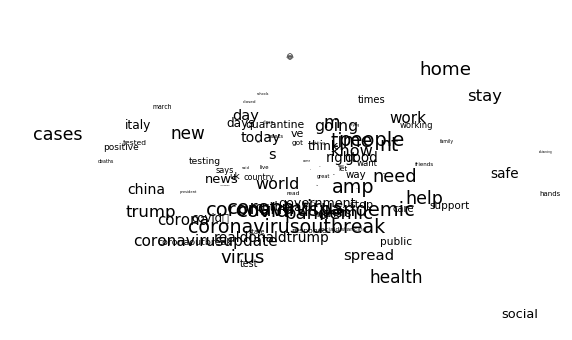

In [104]:
# Multidimensional scaling
MDSWords = sklearn.manifold.MDS(n_components = 2).fit_transform(reducedPCA_data)
plot_words(MDSWords)

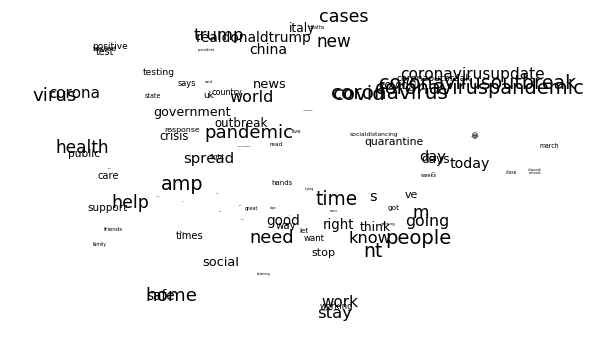

In [105]:
plot_words(tsneWords)

## *late*

In [106]:
# All words contained here
t_late_w2v.wv.index2word[:20] 

['covid',
 'coronavirus',
 'people',
 'amp',
 'coronaviruspandemic',
 'nt',
 'cases',
 'home',
 'pandemic',
 'new',
 'time',
 'help',
 'stay',
 'need',
 'lockdown',
 'health',
 'virus',
 'coronavirusoutbreak',
 'world',
 'support']

In [107]:
t_late_w2v['coronavirus'][:10] 

array([-8.7178755e-01, -6.8528490e-04, -8.4864544e-03,  2.7837265e-01,
        7.6367182e-01, -2.9962647e-01,  3.0212492e-01,  5.1804453e-01,
        2.2133483e-01, -3.0156511e-01], dtype=float32)

In [108]:
t_late_w2v.wv.syn0

array([[-4.71160948e-01, -1.65837221e-02, -6.68767691e-02, ...,
        -5.16132593e-01, -2.03829601e-01,  8.22112441e-01],
       [-8.71787548e-01, -6.85284904e-04, -8.48645438e-03, ...,
        -4.96872395e-01,  1.13634564e-01,  7.08232522e-01],
       [ 4.48251992e-01,  8.93937290e-01, -3.50817293e-01, ...,
        -1.18847884e-01, -2.67284781e-01,  2.80496567e-01],
       ...,
       [ 2.19929554e-02,  3.12178638e-02, -9.09513421e-03, ...,
        -3.90028059e-02,  1.15364604e-02,  5.37860096e-02],
       [ 3.17267887e-02,  3.17857638e-02,  3.10035907e-02, ...,
        -3.91077027e-02,  7.06985546e-03,  4.12937552e-02],
       [ 1.42396577e-02,  3.62170488e-02,  5.97181078e-03, ...,
        -4.93623503e-02,  2.38918979e-02,  6.94254339e-02]], dtype=float32)

In [109]:
t_late_w2v.save("t_late_w2v")

**Most similar words**

In [110]:
t_late_w2v.most_similar('covid',topn=20)

[('coronavirus', 0.7946761250495911),
 ('coronavirusoutbreak', 0.7558690905570984),
 ('dontpanic', 0.718563973903656),
 ('covidー', 0.7123540639877319),
 ('coronaviruspandemic', 0.7033707499504089),
 ('batflu', 0.6884517669677734),
 ('httpstcoydmaxve', 0.6801744699478149),
 ('beatcovid', 0.677742063999176),
 ('coronaoutbreak', 0.6771388649940491),
 ('coronaout', 0.6723691821098328),
 ('swasthabharat', 0.6665536165237427),
 ('handwashchallenge', 0.6632921099662781),
 ('worldhealthorganization', 0.6619250774383545),
 ('coronavirusoutbreakindia', 0.6600897908210754),
 ('uklockdownnow', 0.6571346521377563),
 ('stayhomecanada', 0.6569954752922058),
 ('coronaindia', 0.6560655832290649),
 ('coviduk', 0.6559494137763977),
 ('coronaalert', 0.6554901599884033),
 ('onlineshopping', 0.6543351411819458)]

In [111]:
t_late_w2v.most_similar('mask',topn=20)

[('wear', 0.967120349407196),
 ('face', 0.9614160656929016),
 ('wearing', 0.9601844549179077),
 ('gloves', 0.9428987503051758),
 ('n', 0.9079297780990601),
 ('masks', 0.8997634649276733),
 ('sanitizer', 0.8979142308235168),
 ('surgical', 0.8917690515518188),
 ('hand', 0.8855747580528259),
 ('nose', 0.8747954368591309),
 ('water', 0.8602918386459351),
 ('capes', 0.8543741703033447),
 ('wore', 0.84669429063797),
 ('touching', 0.8457788825035095),
 ('use', 0.8438397645950317),
 ('buy', 0.840024471282959),
 ('shields', 0.8393199443817139),
 ('touch', 0.838141679763794),
 ('soap', 0.8369647264480591),
 ('sew', 0.831843376159668)]

In [112]:
t_late_w2v.most_similar('home',topn=20)

[('indoors', 0.9020514488220215),
 ('tuned', 0.8987055420875549),
 ('inside', 0.898166835308075),
 ('safe', 0.8747637271881104),
 ('homes', 0.8669865131378174),
 ('healthy', 0.8296094536781311),
 ('calm', 0.7812451124191284),
 ('sane', 0.7763264179229736),
 ('away', 0.7762893438339233),
 ('place', 0.7725052237510681),
 ('afloat', 0.771268904209137),
 ('informed', 0.7581678628921509),
 ('strong', 0.746619701385498),
 ('wirbleibenzuhause', 0.7387954592704773),
 ('hunker', 0.7344859838485718),
 ('connected', 0.7234187126159668),
 ('leukemia', 0.720326840877533),
 ('apart', 0.7192078828811646),
 ('metres', 0.7177472114562988),
 ('globalgoals', 0.717718243598938)]

In [113]:
t_late_w2v.most_similar('employment',topn=20)

[('program', 0.9925974607467651),
 ('logistics', 0.9918588995933533),
 ('offers', 0.9906050562858582),
 ('universities', 0.9899783134460449),
 ('legal', 0.9881596565246582),
 ('events', 0.9869744777679443),
 ('deployed', 0.9864145517349243),
 ('hotels', 0.9859444499015808),
 ('institutions', 0.9857660531997681),
 ('eligible', 0.9854413270950317),
 ('hiring', 0.9846822023391724),
 ('projects', 0.9843169450759888),
 ('operational', 0.9842436909675598),
 ('educational', 0.9839816093444824),
 ('safeguards', 0.9832510948181152),
 ('colleges', 0.9832135438919067),
 ('applying', 0.9831883907318115),
 ('offered', 0.9830209016799927),
 ('minimum', 0.9827293157577515),
 ('farmers', 0.9820747375488281)]

In [114]:
t_late_w2v.most_similar('health',topn=20)

[('intensive', 0.7408565282821655),
 ('immune', 0.7186166048049927),
 ('police', 0.7065613865852356),
 ('critical', 0.7048802375793457),
 ('healthcare', 0.7043869495391846),
 ('system', 0.7036856412887573),
 ('facilities', 0.6953127384185791),
 ('systems', 0.6934127807617188),
 ('public', 0.6889002919197083),
 ('general', 0.6855207085609436),
 ('transport', 0.6832893490791321),
 ('underlying', 0.6767025589942932),
 ('ministry', 0.6761752963066101),
 ('issues', 0.6751086711883545),
 ('welfare', 0.6740134954452515),
 ('including', 0.666642427444458),
 ('migrant', 0.661734938621521),
 ('security', 0.6565465927124023),
 ('medical', 0.6521530151367188),
 ('officer', 0.6475181579589844)]

In [115]:
t_late_w2v.most_similar('hospital',topn=20)

[('beds', 0.9310659170150757),
 ('patients', 0.9131675958633423),
 ('icu', 0.912998616695404),
 ('patient', 0.8814699649810791),
 ('hospitals', 0.8805142641067505),
 ('testing', 0.8800046443939209),
 ('treatment', 0.8469926118850708),
 ('underlying', 0.8436368703842163),
 ('currently', 0.8279253840446472),
 ('doctor', 0.8271542191505432),
 ('high', 0.8220677971839905),
 ('w', 0.8185746669769287),
 ('kits', 0.8161507844924927),
 ('center', 0.812798261642456),
 ('hospitalized', 0.8091530203819275),
 ('conditions', 0.805656909942627),
 ('city', 0.8015573620796204),
 ('capacity', 0.796110987663269),
 ('condition', 0.7935131192207336),
 ('intensive', 0.7930217981338501)]

In [116]:
t_late_w2v.most_similar('quarantine',topn=20)

[('selfisolation', 0.8953946232795715),
 ('isolation', 0.8854289650917053),
 ('selfquaratine', 0.8257683515548706),
 ('self', 0.8135181665420532),
 ('selfquarantine', 0.8086565732955933),
 ('isolating', 0.8048456907272339),
 ('quarantinelife', 0.7949913740158081),
 ('stayhome', 0.7949559688568115),
 ('socialdistancing', 0.7905466556549072),
 ('stayathome', 0.7900031805038452),
 ('bored', 0.7752425670623779),
 ('gorgeous', 0.7728331089019775),
 ('policeviolence', 0.7721381187438965),
 ('wfh', 0.770479142665863),
 ('shelterinplace', 0.7698068618774414),
 ('fun', 0.7693813443183899),
 ('abiding', 0.7688226699829102),
 ('selfisolating', 0.7658952474594116),
 ('quarantineandchill', 0.7651349306106567),
 ('illinoislockdown', 0.7604374289512634)]

**Word that is most different from the set**

In [133]:
print(t_late_w2v.similarity('china', 'covid'))

0.2946252


In [117]:
print(t_late_w2v.similarity('employment', 'covid'))

0.33715594


In [118]:
print(t_late_w2v.similarity('quarantine', 'covid'))

0.3371623


In [119]:
print(t_late_w2v.similarity('hospital', 'covid'))

0.136428


In [120]:
print(t_late_w2v.similarity('coronavirus', 'mask'))

0.12753427


In [121]:
print(t_late_w2v.similarity('quarantine', 'home'))

0.5236942


In [122]:
print(t_late_w2v.similarity('mask', 'need'))

0.6267239


**word relations**

In [123]:
# 'coronavirus'+'unemployment' - 'quarantine'
t_late_w2v.most_similar(positive = ['coronavirus','employment'], negative = ['quarantine'], topn = 10)

[('global', 0.807831346988678),
 ('humanitarian', 0.7811460494995117),
 ('funds', 0.7688217163085938),
 ('current', 0.76557856798172),
 ('combined', 0.7651761770248413),
 ('financial', 0.7604192495346069),
 ('facing', 0.7594742774963379),
 ('coordinated', 0.7592013478279114),
 ('dispatched', 0.7566924691200256),
 ('immediate', 0.7556937336921692)]

**visualize**

In [124]:
len(t_late_w2v.wv.index2word)

13374

In [125]:
numWords = 100 
targetWords = t_late_w2v.wv.index2word[:numWords]

In [126]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(t_late_w2v[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-4.71160948e-01, -1.65837221e-02, -6.68767691e-02, ...,
        -5.16132593e-01, -2.03829601e-01,  8.22112441e-01],
       [-8.71787548e-01, -6.85284904e-04, -8.48645438e-03, ...,
        -4.96872395e-01,  1.13634564e-01,  7.08232522e-01],
       [ 4.48251992e-01,  8.93937290e-01, -3.50817293e-01, ...,
        -1.18847884e-01, -2.67284781e-01,  2.80496567e-01],
       ...,
       [ 5.04415810e-01,  1.00542426e+00, -5.64099133e-01, ...,
        -8.29617083e-01,  8.55448395e-02,  1.35654831e+00],
       [ 2.12463036e-01,  3.96110594e-01, -3.99716616e-01, ...,
        -7.78089911e-02, -3.52078408e-01,  2.33571336e-01],
       [ 4.35727745e-01,  3.03592294e-01, -7.24404812e-01, ...,
        -6.00867748e-01, -1.01739457e-02,  8.08694303e-01]], dtype=float32)

In [127]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 128591 missing from current font.
  font.load_char(ord(s), flags=flags)


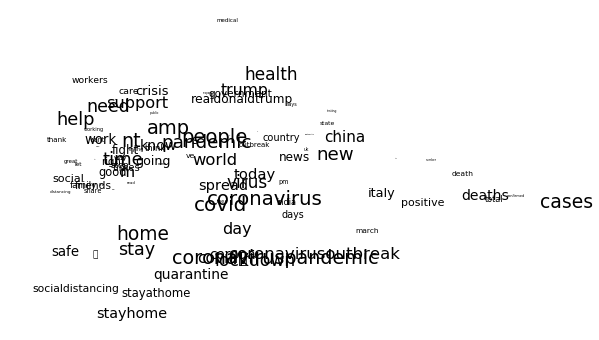

In [128]:
# PCA
PCAWords = sklearn.decomposition.PCA(n_components = 2).fit_transform(wordsSubMatrix)
plot_words(PCAWords)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 128591 missing from current font.
  font.load_char(ord(s), flags=flags)


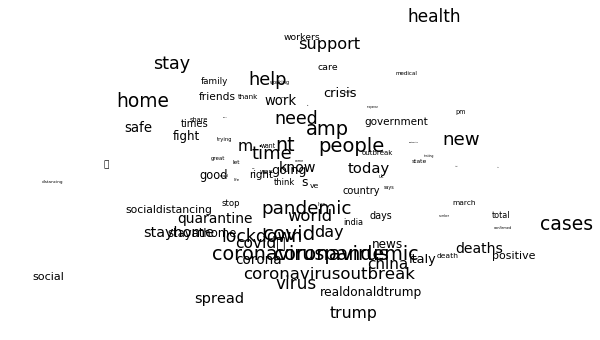

In [129]:
# Multidimensional scaling
MDSWords = sklearn.manifold.MDS(n_components = 2).fit_transform(reducedPCA_data)
plot_words(MDSWords)

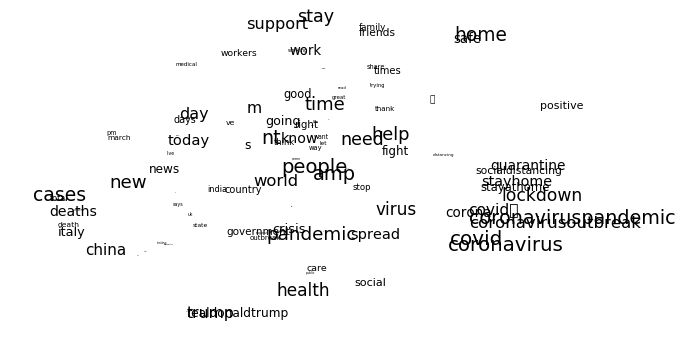

In [130]:
plot_words(tsneWords)

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. 

In [531]:
tweets

,Unnamed: 0,status_id,user_id,created_at,screen_name,text,followers_count,friends_count,clean_text,tokenized_sents,normalized_sents,date
0,0,1.236600e+18,1.113032e+18,2020-03-08T10:31:23Z,GarySch47413717,I remember this with a shudder. A superb Ben E...,155.0,197.0,remember shudder superb ben elton sketch last ...,"[['remember', 'shudder', 'superb', 'ben', 'elt...","[['remember', 'shudder', 'superb', 'ben', 'elt...",2020-03-08
1,1,1.237699e+18,1.215211e+18,2020-03-11T11:17:42Z,KritikaSiroliya,People who die because of Coronavirus should h...,13.0,57.0,people die coronavirus gravestones say quarand...,"[['people', 'die', 'coronavirus', 'gravestones...","[['people', 'die', 'coronavirus', 'gravestones...",2020-03-11
2,2,1.236395e+18,3.248120e+08,2020-03-07T20:56:13Z,kumar_2302,@AUThackeray @OfficeofUT \n\nPrevention is bet...,38.0,106.0,authackeray officeofut prevention better cure ...,"[['authackeray', 'officeofut', 'prevention', '...","[['authackeray', 'officeofut', 'prevention', '...",2020-03-07
3,3,1.237793e+18,3.868509e+08,2020-03-11T17:30:58Z,HEARDatUNSW,Sobering assessment; every country should be d...,2712.0,4994.0,sobering assessment every country still contai...,"[['sobering', 'assessment'], ['every', 'countr...","[['sobering', 'assessment'], ['country', 'cont...",2020-03-11
4,4,1.237867e+18,1.952652e+07,2020-03-11T22:24:15Z,mspanish,"Even if we get a good beat on #covid19, Alaska...",713.0,247.0,even good beat covid alaskans going take huge ...,"[['even', 'good', 'beat', 'covid', 'alaskans',...","[['good', 'beat', 'covid', 'alaskans', 'going'...",2020-03-11
...,...,...,...,...,...,...,...,...,...,...,...,...
95021,4851,1.242737e+18,8.768303e+17,2020-03-25T08:54:54Z,AKRouseSL,Help slow the spread of #COVID19 and identify ...,2806.0,3576.0,help slow spread covid identify risk cases soo...,"[['help', 'slow', 'spread', 'covid', 'identify...","[['help', 'slow', 'spread', 'covid', 'identify...",2020-03-25
95022,4852,1.242725e+18,1.238406e+18,2020-03-25T08:08:17Z,Illumin67953111,Most people tend to see problems as inconvenie...,0.0,14.0,people tend see problems inconvenient disrupti...,"[['people', 'tend', 'see', 'problems', 'inconv...","[['people', 'tend', 'problems', 'inconvenient'...",2020-03-25
95023,4853,1.242838e+18,9.339442e+17,2020-03-25T15:36:40Z,synapse_doc,"#Covid_19 is a modern, retouched version of #P...",201.0,535.0,covid modern retouched version plague call plague,"[['covid', 'modern', 'retouched', 'version', '...","[['covid', 'modern', 'retouched', 'version', '...",2020-03-25
95024,4854,1.242880e+18,2.265559e+09,2020-03-25T18:24:52Z,abbasiam77,Can chloroquine really help treat #COVID19 pat...,457.0,384.0,chloroquine really help treat covid patients h...,"[['chloroquine', 'really', 'help', 'treat', 'c...","[['chloroquine', 'help', 'treat', 'covid', 'pa...",2020-03-25


In [529]:
tweets=pd.read_csv(path+'/tweets.CSV')

In [530]:
tweets['clean_text'] =tweets['clean_text'].astype(str)

In [532]:
tweets['tokenized_words'] = tweets['clean_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tweets['normalized_words'] = tweets['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [248]:
t_middle['tokenized_words'] = t_middle['clean_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
t_middle['normalized_words'] = t_middle['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [533]:
keywords = ['business', 'health', 'government']

In [534]:
def taggedDoc(df):
    taggedDocs = []
    for index, row in df.iterrows():
        #Just doing a simple keyword assignment
        docKeywords = [s for s in keywords if s in row['normalized_words']]
        #docKeywords.append(row['created_at'])
        docKeywords.append(row['user_id']) 
        docKeywords.append(row['date']) 
        taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
    df['TaggedAbstracts'] = taggedDocs
    return df

In [535]:
tweets2 = taggedDoc(tweets)

In [536]:
tweets

,Unnamed: 0,status_id,user_id,created_at,screen_name,text,followers_count,friends_count,clean_text,tokenized_sents,normalized_sents,date,tokenized_words,normalized_words,TaggedAbstracts
0,0,1.236600e+18,1.113032e+18,2020-03-08T10:31:23Z,GarySch47413717,I remember this with a shudder. A superb Ben E...,155.0,197.0,remember shudder superb ben elton sketch last ...,"[['remember', 'shudder', 'superb', 'ben', 'elt...","[['remember', 'shudder', 'superb', 'ben', 'elt...",2020-03-08,"[remember, shudder, superb, ben, elton, sketch...","[remember, shudder, superb, ben, elton, sketch...","([remember, shudder, superb, ben, elton, sketc..."
1,1,1.237699e+18,1.215211e+18,2020-03-11T11:17:42Z,KritikaSiroliya,People who die because of Coronavirus should h...,13.0,57.0,people die coronavirus gravestones say quarand...,"[['people', 'die', 'coronavirus', 'gravestones...","[['people', 'die', 'coronavirus', 'gravestones...",2020-03-11,"[people, die, coronavirus, gravestones, say, q...","[people, die, coronavirus, gravestones, quaran...","([people, die, coronavirus, gravestones, quara..."
2,2,1.236395e+18,3.248120e+08,2020-03-07T20:56:13Z,kumar_2302,@AUThackeray @OfficeofUT \n\nPrevention is bet...,38.0,106.0,authackeray officeofut prevention better cure ...,"[['authackeray', 'officeofut', 'prevention', '...","[['authackeray', 'officeofut', 'prevention', '...",2020-03-07,"[authackeray, officeofut, prevention, better, ...","[authackeray, officeofut, prevention, better, ...","([authackeray, officeofut, prevention, better,..."
3,3,1.237793e+18,3.868509e+08,2020-03-11T17:30:58Z,HEARDatUNSW,Sobering assessment; every country should be d...,2712.0,4994.0,sobering assessment every country still contai...,"[['sobering', 'assessment'], ['every', 'countr...","[['sobering', 'assessment'], ['country', 'cont...",2020-03-11,"[sobering, assessment, every, country, still, ...","[sobering, assessment, country, contain, mitig...","([sobering, assessment, country, contain, miti..."
4,4,1.237867e+18,1.952652e+07,2020-03-11T22:24:15Z,mspanish,"Even if we get a good beat on #covid19, Alaska...",713.0,247.0,even good beat covid alaskans going take huge ...,"[['even', 'good', 'beat', 'covid', 'alaskans',...","[['good', 'beat', 'covid', 'alaskans', 'going'...",2020-03-11,"[even, good, beat, covid, alaskans, going, tak...","[good, beat, covid, alaskans, going, huge, fin...","([good, beat, covid, alaskans, going, huge, fi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95021,4851,1.242737e+18,8.768303e+17,2020-03-25T08:54:54Z,AKRouseSL,Help slow the spread of #COVID19 and identify ...,2806.0,3576.0,help slow spread covid identify risk cases soo...,"[['help', 'slow', 'spread', 'covid', 'identify...","[['help', 'slow', 'spread', 'covid', 'identify...",2020-03-25,"[help, slow, spread, covid, identify, risk, ca...","[help, slow, spread, covid, identify, risk, ca...","([help, slow, spread, covid, identify, risk, c..."
95022,4852,1.242725e+18,1.238406e+18,2020-03-25T08:08:17Z,Illumin67953111,Most people tend to see problems as inconvenie...,0.0,14.0,people tend see problems inconvenient disrupti...,"[['people', 'tend', 'see', 'problems', 'inconv...","[['people', 'tend', 'problems', 'inconvenient'...",2020-03-25,"[people, tend, see, problems, inconvenient, di...","[people, tend, problems, inconvenient, disrupt...","([people, tend, problems, inconvenient, disrup..."
95023,4853,1.242838e+18,9.339442e+17,2020-03-25T15:36:40Z,synapse_doc,"#Covid_19 is a modern, retouched version of #P...",201.0,535.0,covid modern retouched version plague call plague,"[['covid', 'modern', 'retouched', 'version', '...","[['covid', 'modern', 'retouched', 'version', '...",2020-03-25,"[covid, modern, retouched, version, plague, ca...","[covid, modern, retouched, version, plague, pl...","([covid, modern, retouched, version, plague, p..."
95024,4854,1.242880e+18,2.265559e+09,2020-03-25T18:24:52Z,abbasiam77,Can chloroquine really help treat #COVID19 pat...,457.0,384.0,chloroquine really hel

In [537]:
tweets_D2V = gensim.models.doc2vec.Doc2Vec(tweets2['TaggedAbstracts']) #Limiting to 100 dimensions

In [538]:
tweets_D2V.docvecs[1952]

array([-0.00944724, -0.01113185,  0.01034331, -0.01270521, -0.01149586,
       -0.01094904, -0.00387386,  0.00515857,  0.01895185, -0.00311887,
        0.01152909, -0.0154078 , -0.01070913, -0.02611423, -0.00197807,
        0.0113584 , -0.01059575, -0.04016032, -0.01311278, -0.01240623,
        0.02912775, -0.02328047,  0.012389  ,  0.01519553, -0.00604678,
       -0.00479146, -0.01494254,  0.00670888, -0.00541329,  0.00370007,
       -0.01125775, -0.00696997,  0.00669943,  0.00900911,  0.01027095,
        0.02541978, -0.01208153,  0.00291027, -0.0122975 ,  0.00718307,
        0.01719297, -0.01355731, -0.00393203, -0.00964338, -0.00170793,
        0.00736828, -0.01354241,  0.02063713,  0.00751775, -0.00898272,
       -0.00101904,  0.01196939, -0.00441029,  0.00441157, -0.00686843,
        0.0135488 , -0.01112121, -0.01406554,  0.01526789, -0.01361915,
       -0.0092185 ,  0.01893493, -0.01312734, -0.01336498, -0.00723595,
       -0.00282249, -0.02739462,  0.00964466,  0.00484938, -0.00

In [541]:
tweets_D2V.most_similar(positive = ['coronavirus','die'], negative = ['quarantine'], topn = 10)

[('prc', 0.7321560978889465),
 ('spared', 0.7007890939712524),
 ('conceal', 0.6924067139625549),
 ('capitalist', 0.6889759302139282),
 ('erase', 0.6831562519073486),
 ('mistake', 0.6768040657043457),
 ('chooses', 0.6748636960983276),
 ('incompetents', 0.6693326234817505),
 ('isis', 0.6665671467781067),
 ('ccp', 0.6661813855171204)]

In [569]:
tweets_D2V.most_similar(positive = ['coronavirus','unemployment'], negative = ['quarantine'], topn = 10)

[('crippled', 0.7527470588684082),
 ('repo', 0.7455227375030518),
 ('davidndii', 0.7370357513427734),
 ('imf', 0.7356643676757812),
 ('worsens', 0.7348222732543945),
 ('monies', 0.7297657132148743),
 ('moderna', 0.7249673008918762),
 ('bil', 0.7210463285446167),
 ('investments', 0.7191322445869446),
 ('abrupt', 0.71263587474823)]

In [542]:
tweets_D2V.most_similar('home',topn=20)

[('inside', 0.894413948059082),
 ('stylish', 0.8567161560058594),
 ('indoors', 0.8524848222732544),
 ('calm', 0.84672611951828),
 ('indoor', 0.8284932971000671),
 ('away', 0.8273236751556396),
 ('tuned', 0.8065897226333618),
 ('sane', 0.8060049414634705),
 ('slaves', 0.8028801679611206),
 ('strong', 0.8022218942642212),
 ('hydrated', 0.8014959096908569),
 ('homes', 0.8006170988082886),
 ('safe', 0.7978359460830688),
 ('lulu', 0.7960317134857178),
 ('remotely', 0.794701099395752),
 ('chemist', 0.7910518646240234),
 ('grill', 0.7851932048797607),
 ('intact', 0.7840599417686462),
 ('informed', 0.780685544013977),
 ('afloat', 0.7798203229904175)]

In [543]:
tweets_D2V.most_similar('mask',topn=20)

[('wear', 0.962250828742981),
 ('wearing', 0.9526770710945129),
 ('gloves', 0.9386795163154602),
 ('surgical', 0.9378361105918884),
 ('masks', 0.9191844463348389),
 ('face', 0.9167375564575195),
 ('homemade', 0.9124873876571655),
 ('cloth', 0.8930113315582275),
 ('reuse', 0.8881298303604126),
 ('cotton', 0.885045051574707),
 ('wore', 0.8769561052322388),
 ('n', 0.8769251704216003),
 ('disposable', 0.8735134601593018),
 ('sew', 0.8692960739135742),
 ('gowns', 0.8685742616653442),
 ('damp', 0.8619394898414612),
 ('rubber', 0.861600399017334),
 ('filter', 0.8613491058349609),
 ('crypt', 0.8490316867828369),
 ('washable', 0.8488696813583374)]

In [544]:
tweets_D2V.most_similar('covid',topn=20)

[('coronavirus', 0.712731122970581),
 ('coronaviruspandemic', 0.7015467882156372),
 ('coronavirusoutbreak', 0.6760886907577515),
 ('covidー', 0.6691873073577881),
 ('ino', 0.6286684274673462),
 ('writerscommunity', 0.6248790621757507),
 ('hpbsrilanka', 0.6225948333740234),
 ('bearing', 0.6194446086883545),
 ('nizamuddinmarkaz', 0.6141741871833801),
 ('️⃣️⃣', 0.6118367910385132),
 ('nswpol', 0.6081840991973877),
 ('robotics', 0.6070255041122437),
 ('coronavirusnews', 0.6065179705619812),
 ('meghanmccain', 0.6061654090881348),
 ('coronaviruswuhan', 0.6008708477020264),
 ('covidsk', 0.5946162939071655),
 ('🤜', 0.5945422053337097),
 ('microbe', 0.5939949750900269),
 ('preventcovidspread', 0.5923926830291748),
 ('coronaviruscare', 0.5899040102958679)]

In [545]:
tweets_D2V.most_similar('unemployment',topn=20)

[('revenue', 0.9337961673736572),
 ('repo', 0.9227470755577087),
 ('interest', 0.9217000603675842),
 ('crashed', 0.9104493856430054),
 ('cuts', 0.9090235829353333),
 ('raised', 0.9088479280471802),
 ('crunch', 0.9056503772735596),
 ('congressional', 0.9055623412132263),
 ('benefits', 0.9048537611961365),
 ('immigration', 0.9007117748260498),
 ('waived', 0.899989128112793),
 ('borrowers', 0.8994029760360718),
 ('file', 0.8988276720046997),
 ('cynthia', 0.8958545327186584),
 ('consumer', 0.8955869674682617),
 ('dwindling', 0.8953313231468201),
 ('reserves', 0.8947199583053589),
 ('spur', 0.893818736076355),
 ('substantial', 0.8918281197547913),
 ('foldinghome', 0.890113353729248)]

In [546]:
tweets_D2V.most_similar('health',topn=20)

[('relations', 0.8365764617919922),
 ('general', 0.802803635597229),
 ('confidently', 0.7983219623565674),
 ('lav', 0.7977764010429382),
 ('sabotage', 0.7867748737335205),
 ('defender', 0.7863364219665527),
 ('gender', 0.7845973372459412),
 ('aggarwal', 0.7750453352928162),
 ('welfare', 0.7734865546226501),
 ('susannareid', 0.7732248306274414),
 ('justice', 0.770909309387207),
 ('abuse', 0.7689192891120911),
 ('informing', 0.767680287361145),
 ('healthcare', 0.7668037414550781),
 ('tb', 0.7658102512359619),
 ('infrastructure', 0.7650285959243774),
 ('duty', 0.7612237334251404),
 ('core', 0.7609747648239136),
 ('values', 0.7606238722801208),
 ('publicrelations', 0.7586989998817444)]

In [547]:
tweets_D2V.most_similar('hospital',topn=20)

[('icu', 0.9440659880638123),
 ('beds', 0.9422420859336853),
 ('clinic', 0.9310956001281738),
 ('patients', 0.913620114326477),
 ('transferred', 0.9053199291229248),
 ('overflow', 0.9031969308853149),
 ('lopinavir', 0.8985985517501831),
 ('patient', 0.8982025384902954),
 ('mechanical', 0.8927170038223267),
 ('unit', 0.8907941579818726),
 ('gilgitbaltistan', 0.8897199630737305),
 ('skims', 0.8879135847091675),
 ('admitted', 0.8833320736885071),
 ('er', 0.8825514316558838),
 ('facility', 0.8789114356040955),
 ('condition', 0.8772653937339783),
 ('elmhurst', 0.875521183013916),
 ('nurse', 0.8704530596733093),
 ('intubated', 0.8691346049308777),
 ('memorial', 0.8669761419296265)]

In [548]:
tweets_D2V.most_similar('quarantine',topn=20)

[('isolation', 0.8921976089477539),
 ('selfisolation', 0.8880329728126526),
 ('outdoors', 0.8757480978965759),
 ('snacks', 0.8599215745925903),
 ('self', 0.8545185923576355),
 ('confinement', 0.8542624711990356),
 ('selfisolating', 0.8475316762924194),
 ('hermit', 0.845015287399292),
 ('isolating', 0.8420137763023376),
 ('selfquarantine', 0.8380619883537292),
 ('socialdistancing', 0.8237118721008301),
 ('overs', 0.8226363062858582),
 ('fitfam', 0.8127874732017517),
 ('dmv', 0.8095118403434753),
 ('freshair', 0.8081628084182739),
 ('restless', 0.8067786693572998),
 ('apartments', 0.8067275881767273),
 ('adhering', 0.8061392307281494),
 ('silverlining', 0.7999780178070068),
 ('mco', 0.7944450974464417)]

In [551]:
def heatmap(D2V):
    keywords = ['business', 'health', 'government']
    heatmapMatrix = []
    for tagOuter in keywords:
        column = []
        tagVec = D2V.docvecs[tagOuter].reshape(1, -1)
        for tagInner in keywords:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, D2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)
    return heatmapMatrix

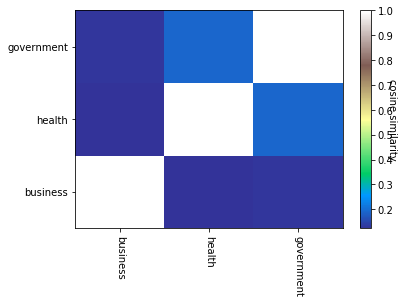

In [552]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmap(tweets_D2V), cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmap(tweets_D2V).shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmap(tweets_D2V).shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Second set of keywords

In [249]:
keywords = ['home', 'mask', 'hospital', 'unemploy', 'business','china','trump']

In [250]:
def taggedDoc(df):
    taggedDocs = []
    for index, row in df.iterrows():
        #Just doing a simple keyword assignment
        docKeywords = [s for s in keywords if s in row['normalized_words']]
        #docKeywords.append(row['created_at'])
        docKeywords.append(row['user_id']) 
        docKeywords.append(row['date']) 
        taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
    df['TaggedAbstracts'] = taggedDocs
    return df

In [251]:
tweets = taggedDoc(tweets)

In [252]:
#t_early = taggedDoc(t_early)
t_middle = taggedDoc(t_middle)
#t_late = taggedDoc(t_late)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Now we can train a Doc2Vec model:

In [264]:
tweets_D2V = gensim.models.doc2vec.Doc2Vec(tweets['TaggedAbstracts']) #Limiting to 100 dimensions

In [265]:
t_middle_D2V = gensim.models.doc2vec.Doc2Vec(t_middle['TaggedAbstracts']) #Limiting to 100 dimensions

In [266]:
tweets_D2V.docvecs[1952]

array([-0.00355948,  0.01570338,  0.0082319 ,  0.00290277,  0.02367098,
        0.01124169,  0.00042136,  0.01496433, -0.01550144, -0.01926011,
        0.00163466,  0.0101212 , -0.00502198,  0.00598547,  0.00099262,
        0.00402529,  0.01920057,  0.00881477, -0.00333056,  0.00083656,
       -0.00077794,  0.00304133,  0.01337029,  0.00171063, -0.01292666,
       -0.00963844, -0.00184522,  0.00288545,  0.01193904, -0.00714251,
        0.02885506,  0.00897219,  0.00200434, -0.01363721, -0.00164889,
        0.00549172, -0.00282486,  0.00336277,  0.0039133 ,  0.00248418,
       -0.00622639, -0.00625132, -0.00309066, -0.0040193 ,  0.00175471,
       -0.01028513,  0.00180658, -0.00858772,  0.00238651,  0.01213815,
        0.00049258, -0.00710822, -0.01600838, -0.01895694,  0.0033494 ,
        0.00343206, -0.00653774,  0.01019723,  0.00386452,  0.0121607 ,
       -0.01015812, -0.00519738,  0.01329672,  0.00049012, -0.0079073 ,
        0.00937037, -0.00344895, -0.00711733, -0.00640881,  0.00

In [172]:
tweets_D2V.most_similar(positive = ['coronavirus','unemployment'], negative = ['quarantine'], topn = 10)

[('stimulus', 0.7428148984909058),
 ('package', 0.733729898929596),
 ('release', 0.7156782150268555),
 ('disaster', 0.7070413827896118),
 ('fed', 0.6879985928535461),
 ('debt', 0.6730920076370239),
 ('senate', 0.6712179780006409),
 ('aid', 0.6630401015281677),
 ('federal', 0.6589062213897705),
 ('economic', 0.6571395993232727)]

In [173]:
tweets_D2V.most_similar('home',topn=20)

[('inside', 0.7630157470703125),
 ('tuned', 0.7472996711730957),
 ('safe', 0.7385143041610718),
 ('afloat', 0.7382889986038208),
 ('hydrated', 0.7310097217559814),
 ('indoors', 0.6941436529159546),
 ('away', 0.6885595321655273),
 ('strong', 0.686705470085144),
 ('compliant', 0.6866974830627441),
 ('calm', 0.6790152788162231),
 ('sane', 0.6777802109718323),
 ('informed', 0.6721887588500977),
 ('connected', 0.6293342113494873),
 ('vigilant', 0.6156201958656311),
 ('hard', 0.6004638671875),
 ('homes', 0.5999728441238403),
 ('open', 0.5914211273193359),
 ('healthy', 0.5890816450119019),
 ('breaching', 0.5827533602714539),
 ('alive', 0.5648211240768433)]

In [174]:
tweets_D2V.most_similar('mask',topn=20)

[('wearing', 0.9495799541473389),
 ('masks', 0.9326369762420654),
 ('wear', 0.9232177734375),
 ('gloves', 0.9028494954109192),
 ('n', 0.8869746923446655),
 ('surgical', 0.878038763999939),
 ('face', 0.8738647699356079),
 ('reuse', 0.8112946152687073),
 ('latex', 0.8006135821342468),
 ('capes', 0.792030930519104),
 ('shields', 0.783248245716095),
 ('inventing', 0.7777981758117676),
 ('wore', 0.7763280272483826),
 ('sanitizers', 0.7733383178710938),
 ('gowns', 0.7725917100906372),
 ('disposable', 0.7636605501174927),
 ('scarf', 0.7555315494537354),
 ('bags', 0.7516893148422241),
 ('suits', 0.7475183010101318),
 ('gear', 0.7395716905593872)]

In [175]:
tweets_D2V.most_similar('covid',topn=20)

[('coronavirus', 0.6896874308586121),
 ('coronavirusoutbreak', 0.6504004001617432),
 ('covidー', 0.5999453663825989),
 ('coviduk', 0.5723999738693237),
 ('hcldr', 0.566379189491272),
 ('socialresponsibility', 0.5653424859046936),
 ('coronaviruspandemic', 0.5639334321022034),
 ('coronavirussymptoms', 0.5552061796188354),
 ('highriskcovid', 0.5465692281723022),
 ('ivf', 0.5462421178817749),
 ('batflu', 0.5443960428237915),
 ('nhsmillion', 0.5430597066879272),
 ('coronauk', 0.5424625277519226),
 ('flattenthecurve', 0.5424352884292603),
 ('coronavirusuk', 0.5419423580169678),
 ('covidupdates', 0.5355822443962097),
 ('healthforall', 0.5319230556488037),
 ('coronaviruscoverup', 0.531039834022522),
 ('closetheschoolsnow', 0.5308496952056885),
 ('keeplearning', 0.5284460783004761)]

In [176]:
tweets_D2V.most_similar('unemployment',topn=20)

[('cut', 0.9113043546676636),
 ('interest', 0.904624342918396),
 ('debt', 0.8727056980133057),
 ('cuts', 0.8710061311721802),
 ('stimulus', 0.8644973635673523),
 ('expected', 0.858100175857544),
 ('tax', 0.8567716479301453),
 ('package', 0.851997971534729),
 ('fed', 0.8468796014785767),
 ('federal', 0.8458130359649658),
 ('airlines', 0.8436106443405151),
 ('massive', 0.8409160375595093),
 ('disaster', 0.836053192615509),
 ('fiscal', 0.8317457437515259),
 ('surveyed', 0.8304224014282227),
 ('emergency', 0.8279049396514893),
 ('admins', 0.8260005712509155),
 ('file', 0.8227752447128296),
 ('received', 0.8224619030952454),
 ('lawmakers', 0.8216419816017151)]

In [177]:
tweets_D2V.most_similar('health',topn=20)

[('general', 0.6893417835235596),
 ('intensive', 0.6605275869369507),
 ('healthcare', 0.6473410725593567),
 ('immune', 0.6200424432754517),
 ('transport', 0.5822939872741699),
 ('prenatal', 0.5729556083679199),
 ('heeded', 0.5711047649383545),
 ('migrant', 0.5704168081283569),
 ('critical', 0.568458080291748),
 ('welfare', 0.5416004061698914),
 ('servants', 0.5260827541351318),
 ('safety', 0.5232753157615662),
 ('heath', 0.5195261240005493),
 ('weakened', 0.5181331634521484),
 ('care', 0.5136484503746033),
 ('system', 0.5126639604568481),
 ('medical', 0.5110551118850708),
 ('underlying', 0.508745551109314),
 ('transportation', 0.5081567168235779),
 ('saeed', 0.5048974752426147)]

In [178]:
tweets_D2V.most_similar('hospital',topn=20)

[('hospitals', 0.8616950511932373),
 ('icu', 0.8599722385406494),
 ('beds', 0.8597155809402466),
 ('patients', 0.8237659931182861),
 ('nursing', 0.8147004246711731),
 ('capacity', 0.7704028487205505),
 ('currently', 0.7639670968055725),
 ('gilgitbaltistan', 0.7635482549667358),
 ('patient', 0.7603548765182495),
 ('medical', 0.7575076818466187),
 ('nurse', 0.7447112798690796),
 ('doctor', 0.7380553483963013),
 ('intensive', 0.7362404465675354),
 ('overrun', 0.7210046648979187),
 ('field', 0.7129378914833069),
 ('overwhelmed', 0.7088659405708313),
 ('rooms', 0.7055585384368896),
 ('center', 0.7047498822212219),
 ('sent', 0.7024325728416443),
 ('ventilator', 0.7011345624923706)]

In [179]:
tweets_D2V.most_similar('quarantine',topn=20)

[('selfisolation', 0.8843644261360168),
 ('isolation', 0.8773632645606995),
 ('selfquarantine', 0.8436365127563477),
 ('isolating', 0.8275821805000305),
 ('self', 0.824189305305481),
 ('quarantined', 0.8234496116638184),
 ('socialdistancing', 0.8215667605400085),
 ('selfisolating', 0.7773644328117371),
 ('break', 0.7391167879104614),
 ('clearwater', 0.7318676710128784),
 ('stayhome', 0.7291554808616638),
 ('bored', 0.722053050994873),
 ('isolationandchill', 0.721092939376831),
 ('isolate', 0.7192310094833374),
 ('outside', 0.7135300636291504),
 ('wfh', 0.712461531162262),
 ('stayathome', 0.7115699052810669),
 ('healthyhabits', 0.7083802223205566),
 ('illinoislockdown', 0.706601619720459),
 ('period', 0.7021017670631409)]

Now let's plot some words and documents against one another with a heatmap:

In [267]:
def heatmap(D2V):
    keywords = ['home', 'mask', 'hospital', 'business']
    heatmapMatrix = []
    for tagOuter in keywords:
        column = []
        tagVec = D2V.docvecs[tagOuter].reshape(1, -1)
        for tagInner in keywords:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, D2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)
    return heatmapMatrix

heatmap for all tweets 

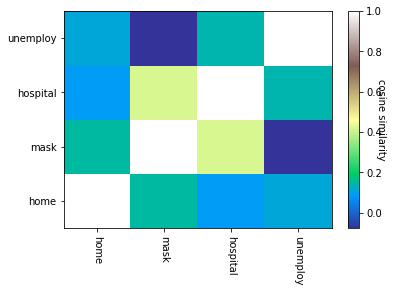

In [268]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmap(tweets_D2V), cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmap(tweets_D2V).shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmap(tweets_D2V).shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

heatmap for t_middle

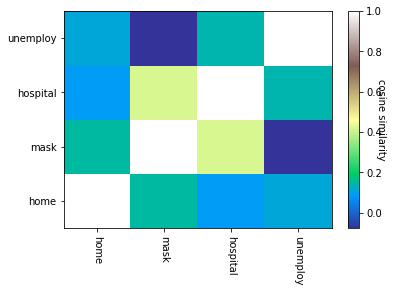

In [269]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmap(tweets_D2V), cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmap(t_middle_D2V).shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmap(t_middle_D2V).shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Similarities between TIME

In [567]:
targetDocs = tweets['date'][1000:1010]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = tweets_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tweets_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

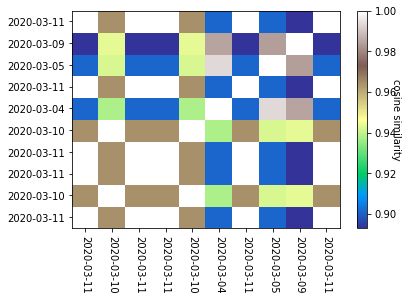

In [568]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [270]:
targetDocs = tweets['date'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = tweets_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tweets_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

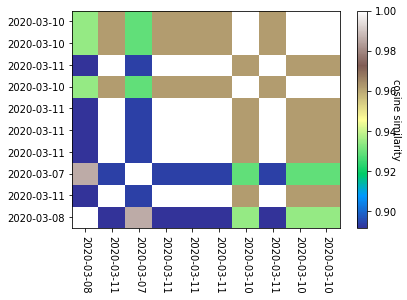

In [271]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [272]:
tweets_D2V.save('tweets_d2v')

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [277]:
tweets_w2v_news = gensim.models.word2vec.Word2Vec(tweets['normalized_sents'].sum())

In [278]:
t_early_w2v_news = gensim.models.word2vec.Word2Vec(t_early['normalized_sents'].sum())
t_middle_w2v_news = gensim.models.word2vec.Word2Vec(t_middle['normalized_sents'].sum())
t_late_w2v_news = gensim.models.word2vec.Word2Vec(t_late['normalized_sents'].sum())

Define some convenient functions for getting dimensions.

In [280]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

First we can visualize with dimension reduction

In [383]:
attitude = dimension(tweets_w2v_news,['agree','good'],['disagree','bad'])
economic = dimension(tweets_w2v_news, ['depression','crisis'], ['boom','growth'])
quarantine = dimension(tweets_w2v_news, ['prohibit', 'ban'], ['welcome', 'accept', 'allow', 'permit'])
#wealth = dimension(tweets_w2v_news, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap'])

In [400]:
attitude_m = dimension(t_middle_w2v_news,['agree','good'],['disagree','bad'])
economic_m = dimension(t_middle_w2v_news, ['depression','crisis'], ['boom','growth'])
quarantine_M = dimension(t_middle_w2v_news, ['prohibit', 'ban'], ['welcome', 'accept', 'allow'])

In [393]:
def makeDF(model, word_list):
    a = []
    e = []
    q = []
    #w = []
    for word in word_list:
        a.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), attitude.reshape(1,-1))[0][0])
        e.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), economic.reshape(1,-1))[0][0])
        q.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), quarantine.reshape(1,-1))[0][0])
        #w.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), wealth.reshape(1,-1))[0][0])

    df = pd.DataFrame({'attitude': a,
                       'economic': e, 'quarantine': q, 
                                                    }, index = word_list)
    return df

Get the projections.

In [385]:
States =['illinois','florida','ny','ohio','pennsylvania','washington','california']

In [394]:
STAdf = makeDF(tweets_w2v_news, States)

In [401]:
STAdf_m = makeDF(t_middle_w2v_news, States)

In [395]:
STAdf

,attitude,economic,quarantine
illinois,-0.356392,-0.431322,-0.397023
florida,-0.401729,-0.618313,-0.151422
ny,-0.353061,-0.433273,-0.253394
ohio,-0.330886,-0.474813,-0.309760
pennsylvania,-0.311503,-0.329371,-0.481022
washington,-0.288922,-0.339746,-0.176310
california,-0.333568,-0.408834,-0.200701


In [571]:
list(plt.cm.rainbow([-0.356392, -0.288922]))


[array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ])]

Define some useful functions for plotting.

In [287]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    #ylim(bottem,top)
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

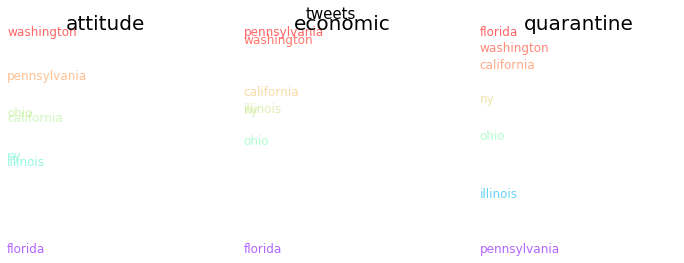

In [398]:
fig = plt.figure(figsize = (12,4))
fig.suptitle('tweets',fontsize=15)
ax1 = fig.add_subplot(131)
PlotDimension(ax1, STAdf, 'attitude')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, STAdf, 'economic')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, STAdf, 'quarantine')

plt.show()

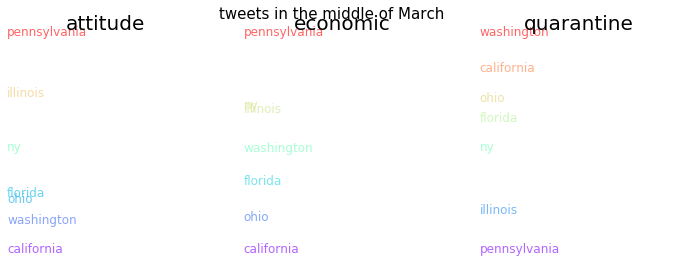

In [402]:
fig = plt.figure(figsize = (12,4))
fig.suptitle('tweets in the middle of March',fontsize=15)
ax1 = fig.add_subplot(131)
PlotDimension(ax1, STAdf_m, 'attitude')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, STAdf_m, 'economic')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, STAdf_m, 'quarantine')

plt.show()